In [1]:
import numpy as np


from Bolu_IFG.utils import *
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import collections
from sklearn.decomposition import PCA
from torchtext import vocab as Vocab
from Bolu_IFG.AlignPhonemeNet import AlignPhonemeNet
from sklearn.manifold import TSNE
from tqdm import tqdm
#from gruut import sentences
from abydos.abydos import distance as D
from sklearn.cross_decomposition import CCA
# Download the CMU Pronouncing Dictionary
nltk.download('cmudict')
# Create a sentence to phoneme dictionary

words_to_phonemes = nltk.corpus.cmudict.dict()

[nltk_data] Downloading package cmudict to /Users/tlc0494/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
/Users/tlc0494/opt/miniconda3/envs/mini_rotation_josh_aarch64/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/tlc0494/opt/miniconda3/envs/mini_rotation_josh_aarch64/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecatio

In [2]:
band='spike_band' ## this could be high gamma band or spike band
date = 'Jan05_2024'  # here we have Jan05_2024,
raw_data_jan = get_raw(date, band)
date = 'Dec06_2023'  # here we have Jan05_2024, Dec06_2023 data
raw_data_dec = get_raw(date, band)
fs = 2000

## Align the data across days for better results
In Gallego's paper they used single trial based alignment. Here based on lack of the trial we are doing trial averaged alignment.

In [3]:
# first step: find the common words
answered_words_jan = [a[0][0][0] for a in raw_data_jan[8].to_numpy()] 
answered_words_dec=[a[0][0][0] for a in raw_data_dec[8].to_numpy()] 
answered_words_common=list(set(answered_words_jan) & set(answered_words_dec))
print(answered_words_common)

['k', 'p', 'r', 't', 'c', 'b']


In [4]:
# find the trials in both days. Data to align: 0-500ms after speech onset. Trial averaged for each word.
raw_data_jan_clean,_,_,_,_= data_cleaning(raw_data_jan)
raw_data_dec_clean,_,_,_,_= data_cleaning(raw_data_dec)
n_trials_dec=len(raw_data_dec_clean)
n_trials_jan=len(raw_data_jan_clean)
_,reject_channels,_,_,_ = data_cleaning(pd.concat([raw_data_jan,raw_data_dec]))

/Users/tlc0494/Library/CloudStorage/OneDrive-NorthwesternUniversity/PycharmProjects/Speech/Bolu_IFG/utils.py:140: RuntimeWarning: Mean of empty slice.
  trial_std = np.array([t.mean(axis=0).std() for t in channel_clean_data])
/Users/tlc0494/opt/miniconda3/envs/mini_rotation_josh_aarch64/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [5]:
back=0.5
forward=0.5
process_data_dec=[]
process_data_jan=[]
for word in answered_words_common:
    raw_data_dec_clean_common=raw_data_dec_clean[raw_data_dec_clean[8]==word]
    raw_data_jan_clean_common=raw_data_jan_clean[raw_data_jan_clean[8]==word]
    
    clean_data_dec_common=[np.delete(a,reject_channels,axis=0) for a in raw_data_dec_clean_common[1].to_list()]
    clean_data_jan_common=[np.delete(a,reject_channels,axis=0) for a in raw_data_jan_clean_common[1].to_list()]
    
    voice_on_dec = raw_data_dec_clean_common[6].to_numpy()
    voice_on_jan = raw_data_jan_clean_common[6].to_numpy()
    
    processed_data_voice_on_dec=np.mean([trial[:,int(voice_on_dec[i]*fs-back*fs) : int(voice_on_dec[i]*fs+forward*fs)] for i,trial in enumerate(clean_data_dec_common)],axis=0)
    processed_data_voice_on_jan=np.mean([trial[:,int(voice_on_jan[i]*fs-back*fs) : int(voice_on_jan[i]*fs+forward*fs)] for i,trial in enumerate(clean_data_jan_common)],axis=0)
    
    process_data_dec.append(processed_data_voice_on_dec)
    process_data_jan.append(processed_data_voice_on_jan)
process_data_jan=np.concatenate(process_data_jan,axis=-1)
process_data_dec=np.concatenate(process_data_dec,axis=-1)

/Users/tlc0494/opt/miniconda3/envs/mini_rotation_josh_aarch64/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tlc0494/opt/miniconda3/envs/mini_rotation_josh_aarch64/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-dimensional arrays cannot be concatenated

In [6]:
cca=CCA(n_components=10)
#cca.fit(process_data_dec.T,process_data_jan.T) # here fit jan data to align to dec data. (the reverse should be fine? but need to change the following steps)

rejected_channels: [ 0  0  0 ... 63 63 63] 

rejected_trials: [  0  32  64  65  91 103 108 109 110 111 112 130 246 281 301]


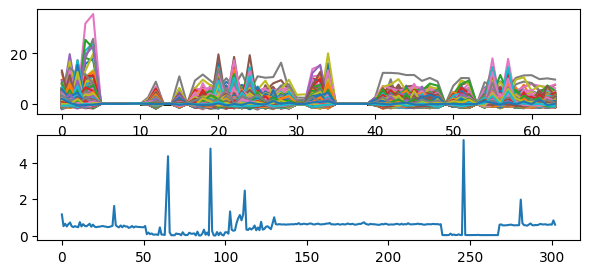

In [7]:
# concatenate data
raw_data = pd.concat([raw_data_jan,raw_data_dec])
# clean the data
raw_data,reject_channels,reject_trials,channel_std,trial_std = data_cleaning(raw_data)
print(f"rejected_channels: {reject_channels} \n")
print(f"rejected_trials: {reject_trials}")

clean_data=[np.delete(a,reject_channels,axis=0) for a in raw_data[1].to_list()]

fig,ax=plt.subplots(2,1,figsize=(7,3))
ax[0].plot(channel_std)
ax[1].plot(trial_std)
plt.show()

In [8]:
# process the labels
correct_syntax_labels = raw_data[10].to_numpy() # syntax labels: 1,2,3: past, present, past+s
answered_syntax_labels = raw_data[11].to_numpy() # syntax labels: 1,2,3: past, present, past+s
answered_words = raw_data[8].to_numpy() 
answered_words=[a[0][0][0] for a in answered_words] # answered lexical items
answered_semantic_labels=raw_data[12].to_numpy() # answered semantic categories
correct_syntax_labels = np.array([a[0] for a in correct_syntax_labels])
answered_syntax_labels = np.array([a[0] for a in answered_syntax_labels])
answered_semantic_labels=np.array([a[0] if a!=np.NaN else np.NaN for a in answered_semantic_labels])

# turn the lexical items into lexemes; root of the words
lemmatizer = WordNetLemmatizer()
answered_lexemes = [lemmatizer.lemmatize(a, pos='v') for a in answered_words]
answered_lexemes=np.array(['stare' if a =='star' else a for a in answered_lexemes])

# process the time stamps
phrase_on = raw_data[2].to_numpy()
word_on = raw_data[4].to_numpy()
voice_on = raw_data[6].to_numpy()
voice_off = raw_data[7].to_numpy()

phrase_on = np.array([a[0][0] for a in phrase_on])
word_on = np.array([a[0][0] for a in word_on])
voice_on = np.array([a[0][0] for a in voice_on])
voice_off = np.array([a[0][0] for a in voice_off])

# recording frequency rate

print(collections.Counter(answered_lexemes))
print(collections.Counter(answered_semantic_labels))
print(collections.Counter(answered_syntax_labels))

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [9]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=2 # looking back 3 seconds before onset
forward=1 # looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_voice_on=[cca.predict(trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)].T).T if i>=n_trials_jan 
                         else trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)]for i,trial in enumerate(clean_data)]
n_channels=processed_data_voice_on[0].shape[0]
n_trials_total=len(processed_data_voice_on)
binned_data_voice_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_voice_on]
binned_data_voice_on_averaged=np.mean(binned_data_voice_on,axis=0)
n_bins=binned_data_voice_on_averaged.shape[-1]

ave_voice_on=back

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: binned",fontsize=20)
plt.show()

NotFittedError: This CCA instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# here we do alignment between the neural signal to phoneme space/distance matrix

In [10]:
######################### phoneme "embedding" ########################################
aline=D.ALINE
phoneme_embed_ipa=aline(phones='ipa')
answered_phonemes=[convert_to_ipa(x) for x in answered_words]
#phoneme_embed=D.PhoneticEditDistance()
all_dist_ipa=np.array([[phoneme_embed_ipa.sim(answered_phonemes[j],answered_phonemes[i]) for i in range(len(answered_words))] for j in range(len(answered_words))])

# get the unique words for the distance matrix display
# This is from display
answered_words_unique=np.unique(answered_words)
answered_phonemes_unique=[convert_to_ipa(x) for x in answered_words_unique]
unique_dist_ipa=np.array([[phoneme_embed_ipa.sim(answered_phonemes_unique[j],answered_phonemes_unique[i]) for i in range(len(answered_words_unique))] for j in range(len(answered_words_unique))])

In [10]:
# fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.imshow(unique_dist_ipa)
# ax.set_title("IPA")
# ax.set_xticks(list(range(len(answered_words_unique))))
# ax.set_xticklabels(answered_words_unique,rotation=90)
# ax.set_yticks(list(range(len(answered_words_unique))))
# ax.set_yticklabels(answered_words_unique)
# plt.show()

# Doing phoneme similarity regression using in house nonlinear method
The goal is to train a low D embedding of which distance matrix mimics the word-phoneme similarity matrix

In [11]:
# prepare the data
data_to_use=np.array(binned_data_voice_on).swapaxes(1,2)
embedding_to_use=np.copy(all_dist_ipa) # here this embedding is a similarity matrix

# Here we are trying to do some regression task. It's shown that the dataset m
preprocess_dim=30
n_CC=5 # low D embedding size
### preprocesing 
preprocessor=PCA(n_components=preprocess_dim)
# define how many bins history we want in each feature
n_bins_per_feature=10

# reformat the data: for each time bin we include n_bins_per_feature of history
X=reformat(data_to_use,n_bins_per_feature) # data is a list

#### Start decoding for every time bin ####
n_repeat=20
averaged_training=[]
averaged_score=[]
averaged_chance=[]

for j in tqdm(range(n_repeat), desc='repeats', unit='rep.'):
    score=[]
    chance=[]
    training_score=[]
    for n_bin in range(len(X)):
        # split the train and test set
        X_, X_test, _, _,train_index,test_index =get_train_test(X[n_bin],embedding_to_use,train=0.8)
        y_train=select_submatrix(embedding_to_use,list(train_index))
        y_test=select_submatrix(embedding_to_use,list(test_index))
        
        # decrease the dimension
        preprocessor.fit(X_)
        X_low_D=preprocessor.transform(X_)
        X_test_low_D=preprocessor.transform(X_test)

        # normalize data by each sample
        X_low_D=(X_low_D-np.mean(X_low_D,axis=1,keepdims=True))/np.std(X_low_D,axis=1,keepdims=True)
        X_test_low_D=(X_test_low_D-np.mean(X_test_low_D,axis=1,keepdims=True))/np.std(X_test_low_D,axis=1,keepdims=True)
        
        # split the train and val set
        X_train_low_D, X_val_low_D, _, _,train_index,val_index =get_train_test(X_low_D,y_train,train=0.8)
        y_train_new=select_submatrix(y_train,list(train_index))
        y_val=select_submatrix(y_train,list(val_index))
        
        # train the model
        extractor=AlignPhonemeNet(n_features=X_low_D.shape[1],n_low_D=n_CC,metric='l2')  
        extractor.fit_minibatch(X_train_low_D,y_train_new,
                      X_val_low_D,y_val,
                      n_epochs=800, batch_size=100, patience=0,
                      learning_rate=0.005,lambda_l1=0.001,device='cuda')
        tr_sc=extractor.score(X_train_low_D,y_train_new)
        sc=extractor.score(X_test_low_D,y_test)
        
        # train the model with shuffled data
        extractor=AlignPhonemeNet(n_features=X_low_D.shape[1],n_low_D=n_CC)  
        np.random.shuffle(X_train_low_D.T)
        np.random.shuffle(X_val_low_D.T)
        extractor.fit_minibatch(X_train_low_D,y_train_new,
                      X_val_low_D,y_val,
                      n_epochs=800, batch_size=100, patience=0,
                      learning_rate=0.005,lambda_l1=0.001,device='cuda')
        ch=extractor.score(X_test_low_D,y_test)
        
        score.append(sc)
        chance.append(ch)
        training_score.append(tr_sc)
    averaged_score.append(score)
    averaged_chance.append(chance)
    averaged_training.append(training_score)
 

NameError: name 'binned_data_voice_on' is not defined

In [12]:
alpha = 1
#percentile_bybin = np.percentile(averaged_accuracy,alpha,axis=0)
#p_illustration=['*' if 0.05<percentile_bybin[i] else '' for i in range(n_bins)]

# percentile_bybin = np.percentile(averaged_score,alpha,axis=0)
# p_illustration=['*' if percentile_bybin[i]>0 else '' for i in range(n_bins)]

percentile_bybin = np.percentile(averaged_score,100-alpha,axis=0)
p_illustration=['*' if percentile_bybin[i]<np.mean(averaged_chance,axis=0)[i]-0.08 else '' for i in range(n_bins)]

NameError: name 'averaged_score' is not defined

NameError: name 'n_bins' is not defined

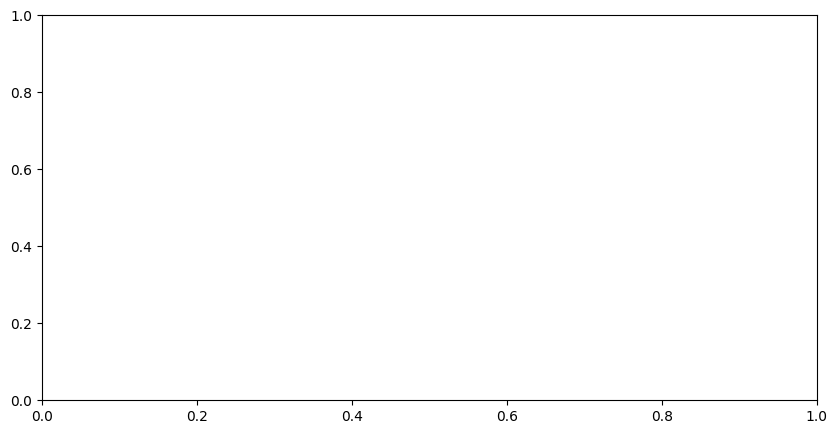

In [13]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_training,axis=0),lw=3,color='m',alpha=0.2)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_score,axis=0),lw=3)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0)-0.08,lw=2,linestyle='--',color='orange')
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
                np.mean(averaged_score,axis=0)-np.std(averaged_score,axis=0),
               np.mean(averaged_score,axis=0)+np.std(averaged_score,axis=0),alpha=0.2)
#ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
#                np.mean(averaged_training,axis=0)-np.std(averaged_training,axis=0),
#               np.mean(averaged_training,axis=0)+np.std(averaged_training,axis=0),alpha=0.2,color='m')
#ax.axhline(0,lw=2,linestyle='--',color='orange')

#ax.boxplot(averaged_accuracy_.T,positions=np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),showfliers=False)
#ax2=ax.twinx()
#ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
# ax.axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
# ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
ax.set_xticks(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),10), [f"{i:0.1f}" for i in np.linspace(-back,forward,10)])
#ax.set_ylim([-2,1])
ax.set_xlabel("time (s)")
ax.set_ylabel("L2 distance")
for label, loc in zip(p_illustration,np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins)):
    ax.text(loc, 0.15, label, ha='center', va='center')

plt.show()

   ### Here we would like to look at the bin where there is the most whole-word phoneme information

In [14]:
best_bin=np.argmin(np.mean(averaged_score,axis=0))
best_bin

NameError: name 'averaged_score' is not defined

In [15]:
data_to_use=np.array(binned_data_voice_on).swapaxes(1,2)
embedding_to_use= np.copy(all_dist_ipa)

NameError: name 'binned_data_voice_on' is not defined

### Here we calculate a projection matrix only for the "best bin"

In [16]:
n_bins_best_performance=36 # derived from previous analysis
n_low=5
n_bins_per_feature=5
preprocess_dim=40
# run a model using that bin
X=reformat(data_to_use,n_bins_per_feature) # data is a list
X_best=X[n_bins_best_performance]

X_, X_test, _, _,train_index,test_index =get_train_test(X_best,embedding_to_use,train=0.9)
y_train=select_submatrix(embedding_to_use,list(train_index))
y_test=select_submatrix(embedding_to_use,list(test_index))

preprocessor=PCA(n_components=preprocess_dim)
preprocessor.fit(X_)
X_low_D=preprocessor.transform(X_)       
X_test_low_D=preprocessor.transform(X_test)

# normalize data
X_low_D=(X_low_D-np.mean(X_low_D,axis=1,keepdims=True))/np.std(X_low_D,axis=1,keepdims=True)
X_test_low_D=(X_test_low_D-np.mean(X_test_low_D,axis=1,keepdims=True))/np.std(X_test_low_D,axis=1,keepdims=True)

# split the train and val set
X_train_low_D, X_val_low_D, _, _,train_index_,val_index =get_train_test(X_low_D,y_train,train=0.8)
y_train_new=select_submatrix(y_train,list(train_index_))
y_val=select_submatrix(y_train,list(val_index))

extractor=AlignPhonemeNet(n_features=X_train_low_D.shape[1],
                       n_low_D=n_low)
extractor.fit_minibatch(X_train_low_D,y_train_new,X_val_low_D,y_val,
                      n_epochs=800, batch_size=20, patience=100,
                      learning_rate=0.002,lambda_l1=0.001,device='cuda',sim_metric='l2')
# extractor.fit(X_train_low_D,y_train_new,X_val_low_D,y_val,
#                       num_iterations =800,
#                       learning_rate=0.005,lambda_l1=0.001,device='cuda')

X_embed_test=extractor.predict(X_test_low_D)
X_embed_train=extractor.predict(X_train_low_D)
score=extractor.score(X_test_low_D,y_test,device='cuda',sim_metric='l2')
print(score)

NameError: name 'data_to_use' is not defined

In [17]:
plt.figure()
plt.plot(extractor.training_loss)
plt.plot(extractor.validation_loss)
plt.axvline(np.argmin(extractor.validation_loss))
plt.show()

NameError: name 'extractor' is not defined

<Figure size 640x480 with 0 Axes>

In [18]:
plt.close()

In [19]:
# linear_x=extractor.linear_X.weight.cpu().detach().numpy()
X_embed_train=X_embed_train.detach().cpu().numpy()
X_embed_test=X_embed_test.detach().cpu().numpy()
# fig,ax=plt.subplots(1,1,figsize=(10,5))
# ax.imshow(linear_x)
# plt.show()

NameError: name 'X_embed_train' is not defined

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

train_cos=cosine_similarity(X_embed_train,X_embed_train)
test_cos=cosine_similarity(X_embed_test,X_embed_test)
train_cov=np.cov(X_embed_train,X_embed_train)/np.var(X_embed_train)

fig,ax=plt.subplots(2,2,figsize=(10,10))
im=ax[0][0].imshow(train_cos)
im.set_clim(0,1)
plt.colorbar(im,shrink=0.3)
im=ax[1][0].imshow(test_cos)
ax[1][0].set_title("Neural Space")
im.set_clim(0,1)
plt.colorbar(im,shrink=0.3)
im=ax[0][1].imshow(y_train)
im.set_clim(0,1)

plt.colorbar(im,shrink=0.3)
im=ax[1][1].imshow(y_test)
im.set_clim(0,1)
plt.colorbar(im,shrink=0.3)
ax[1][1].set_title("Linguistic Space")
plt.show()

NameError: name 'X_embed_train' is not defined

In [21]:
#train_illustration=PCA(n_components=2).fit_transform(np.concatenate([X_embed_train]))
#test_illustration=PCA(n_components=2).fit_transform(np.concatenate([X_embed_test]))

#train_illustration=TSNE(n_components=2).fit_transform(X_embed_train)
test_illustration=TSNE(n_components=2,perplexity=10).fit_transform(X_embed_test)

#X_train_illustration= train_illustration
X_test_illustration= test_illustration

fig,ax=plt.subplots(1,1,figsize=(10,10))
# for i,w in enumerate(X_train_illustration):
#     ax[0].scatter(w[1],w[0],color='k',s=1)
#     ax[0].text(w[1],w[0],answered_words[train_index[i]],fontsize=12)
    
for i,w in enumerate(X_test_illustration):
    ax.scatter(w[1],w[0],color='k',s=1)
    ax.text(w[1],w[0],answered_words[test_index[i]],fontsize=12)

plt.show()

NameError: name 'X_embed_test' is not defined

### Use the trained weight at this time bin to project other data to this space

In [22]:
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.ndimage import gaussian_filter1d

all_low_D_x_bin=[]
preprocessor=PCA(n_components=preprocess_dim)
for x_bin in X[:40]:
    if x_bin.shape[-1]==X[-1].shape[-1]:
        preprocessor.fit(x_bin[train_index])     
        X_test_low_D=preprocessor.transform(x_bin[test_index])
        
        # normalize data
        X_test_low_D=(X_test_low_D-np.mean(X_test_low_D,axis=1,keepdims=True))/np.std(X_test_low_D,axis=1,keepdims=True)

        low_D_x_bin=extractor.predict(X_test_low_D,device='cuda') 
        all_low_D_x_bin.append(low_D_x_bin.detach().cpu().numpy())
all_low_D_x_bin=np.concatenate(all_low_D_x_bin)

illustration=PCA(n_components=3).fit_transform(all_low_D_x_bin).reshape(-1,len(test_index),3)
# smooth the trajectory a little bit to see it makes more sense
smoothed_illustration=gaussian_filter1d(illustration,sigma=10, axis=0)


NameError: name 'X' is not defined

In [23]:
%matplotlib notebook
picked_words=['date','dated','dates','bake','baked','bakes','look','looks','looked','rub','rubs','rubbed','talk','talks','talked']
picked_color=['r','r','r','b','b','b','m','m','m','c','c','c']
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection='3d')
# scatter=ax.scatter(illustration[0,:,0],illustration[0,:,1],color='k',s=1)
# text_object=[]
# for i,w in enumerate(illustration[0]):   
#     text_object.append(ax.text(w[1],w[0],answered_words[test_index[i]],fontsize=10))
# # ax.set_xlim(-3,2)
# # ax.set_ylim(-1,2)
# def update(frame):
#     scatter.set_offsets(illustration[frame])
#     for i, text in enumerate(text_object):
#         text.set_position([illustration[frame,i,0],illustration[frame,i,1]])
#         text.set_text(answered_words[test_index[i]])
#         text.set_fontsize(10)
#     return scatter,*text_object
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'
# ani=FuncAnimation(fig,update,frames=len(illustration),blit=True)
# ani.save('scatter_text_animation.mp4', writer='ffmpeg', fps=1)

# cmap = cm.get_cmap('Reds', len(illustration))
# for frame in range(len(illustration)):
#     ax.scatter(smoothed_illustration[frame,:,0],smoothed_illustration[frame,:,1],color=cmap(frame),s=1)

# for word_id in range(len(test_index)):
#     if answered_words[test_index[word_id]] in picked_words:
#         if lemmatizer.lemmatize(answered_words[test_index[word_id]],pos='v')=='date':
#             ax.plot(smoothed_illustration[:,word_id,0],smoothed_illustration[:,word_id,1],smoothed_illustration[:,word_id,2],alpha=0.6,color='r')
#         if lemmatizer.lemmatize(answered_words[test_index[word_id]],pos='v')=='bake':
#             ax.plot(smoothed_illustration[:,word_id,0],smoothed_illustration[:,word_id,1],smoothed_illustration[:,word_id,2],alpha=0.6,color='b')
#         if lemmatizer.lemmatize(answered_words[test_index[word_id]],pos='v')=='look':
#             ax.plot(smoothed_illustration[:,word_id,0],smoothed_illustration[:,word_id,1],smoothed_illustration[:,word_id,2],alpha=0.6,color='m')
#         if lemmatizer.lemmatize(answered_words[test_index[word_id]],pos='v')=='boot':
#             ax.plot(smoothed_illustration[:,word_id,0],smoothed_illustration[:,word_id,1],smoothed_illustration[:,word_id,2],alpha=0.6,color='c')

for i,w in enumerate(smoothed_illustration[-1,:,:]):   
    if answered_words[test_index[i]] in picked_words:
        ax.text(w[0],w[1],w[2],answered_words[test_index[i]],fontsize=15)
        ax.scatter(w[0],w[1],w[2],s=3,color='k')



<IPython.core.display.Javascript object>

NameError: name 'smoothed_illustration' is not defined

In [23]:
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'
# ani.save('scatter_text_animation.mp4', writer='ffmpeg', fps=1)

In [90]:
import pickle
with open('3D_object.pk','wb') as f:
    pickle.dump(fig,f)